In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import cmasher as cmr
import glob
import datetime

In [3]:
#Coordenadas de estaciones 
cor=pd.read_csv("clustering_Had.csv")

#Seleciconando las latitudes y las longitudes
lat=cor.lat
lon=cor.Lon

In [5]:
#Encontrando las estaciones dentro de MSD sigueindo el método García-Franco et al. (2021)
#11,18,-96,-88 coordenadas de zona MSD
sid_MSD=cor.loc[(cor.lat>=11)&(cor.lat<=18.5)&(cor.Lon>=-97)&(cor.Lon<=-88)]

In [6]:
sid_MSD=sid_MSD.loc[(sid_MSD.index!=82)&(sid_MSD.index!=87)] #Quitando dos estaciones que tienen tendencia a enfriamiento en Tw

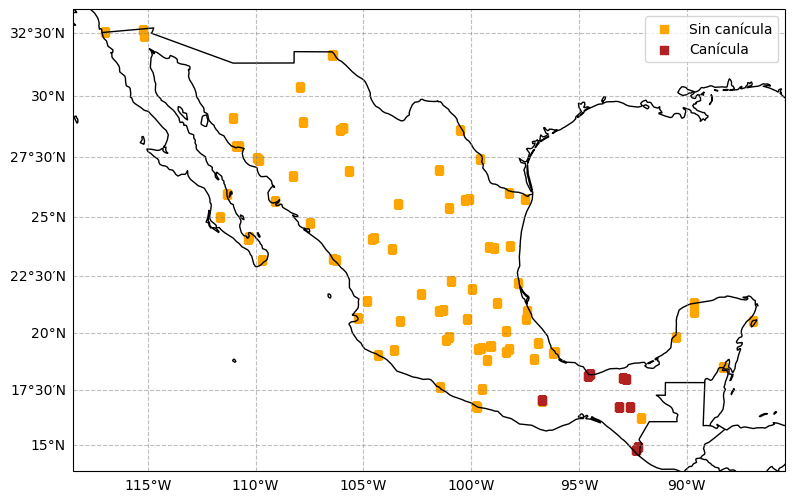

In [7]:
#Mostrando la clasificación
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Mercator()})

ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False
gl.top_labels = gl.right_labels = False
ax.add_feature(cfeature.BORDERS)


ax.scatter(lon,lat,color='orange', marker='s', s=30,label='Sin canícula', transform=ccrs.PlateCarree())
ax.scatter(sid_MSD["Lon"].astype(float), sid_MSD["lat"].astype(float),color='firebrick', marker='s', s=30,label='Canícula', transform=ccrs.PlateCarree())
plt.legend()

plt.savefig("MSD_stations.svg")
plt.savefig("MSD_stations.png")
plt.show()

In [8]:
#Cargando los datos de ERA5-Land
# Usar glob para seleccionar todos los archivos CSV en la ruta
archivos_nc = sorted(glob.glob("/home/andreagvc/data/ERA/ERA/ERA_*_hourly_rec*.nc"))

#Combinando los datos de ERA
ds_combinado=xr.open_mfdataset(archivos_nc,combine="by_coords")

In [9]:
#Seleccionando las variables con las estaciones dentro del área de MSD

Tw_ERA=ds_combinado.TWB_d.loc[ds_combinado.TWB_d.sid.isin(sid_MSD)]
T_ERA=ds_combinado.T_d.loc[ds_combinado.T_d.sid.isin(sid_MSD)]
q_ERA=ds_combinado.q_d.loc[ds_combinado.q_d.sid.isin(sid_MSD)]

In [10]:
#Agrupando por semanas del año
ERA_Tw_week=Tw_ERA.groupby(Tw_ERA['time'].dt.isocalendar().week).mean(["time","sid"])
ERA_T_week=T_ERA.groupby(T_ERA['time'].dt.isocalendar().week).mean(["time","sid"])
ERA_q_week=q_ERA.groupby(Tw_ERA['time'].dt.isocalendar().week).mean(["time","sid"])

In [11]:
#Cargando los datos de las estaciones para hacer la comparación con ERA5-Land
df=pd.read_csv("/home/andreagvc/data/ERA/ERA/IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("/home/andreagvc/data/ERA/ERA/ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_181810/1445211296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [12]:
#Cargando los datos de las estaciones Had_ISD
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)

In [13]:
HAD=xr.concat(da_list,dim='estacion') #Archivo concatenado

In [14]:
#Seleccionando las variables promedio para hacer la comparación
HAD_Tw=(HAD.Twmean.where(HAD.Twmean.time.dt.year>1978, drop=True)).loc[HAD.Twmean.estacion.isin(sid_MSD)]
HAD_T=(HAD.Tmean.where(HAD.Tmean.time.dt.year>1978, drop=True)).loc[HAD.Tmean.estacion.isin(sid_MSD)]
HAD_SH=(HAD.SHmean.where(HAD.SHmean.time.dt.year>1978, drop=True)).loc[HAD.SHmean.estacion.isin(sid_MSD)]

In [15]:
#Promediando por semana del año
HAD_Tw_week=HAD_Tw.groupby(HAD_Tw['time'].dt.isocalendar().week).mean(["time","estacion"])
HAD_T_week=HAD_T.groupby(HAD_T['time'].dt.isocalendar().week).mean(["time","estacion"])
HAD_SH_week=HAD_SH.groupby(HAD_SH['time'].dt.isocalendar().week).mean(["time","estacion"])

In [16]:
#Seleccionando las variables promedio de las estaciones sin canícula
HAD_Tw_nMSD=(HAD.Twmean.where(HAD.Twmean.time.dt.year>1978, drop=True)).loc[~HAD.Twmean.estacion.isin(sid_MSD)]
HAD_T_nMSD=(HAD.Tmean.where(HAD.Tmean.time.dt.year>1978, drop=True)).loc[~HAD.Tmean.estacion.isin(sid_MSD)]
HAD_SH_nMSD=(HAD.SHmean.where(HAD.SHmean.time.dt.year>1978, drop=True)).loc[~HAD.SHmean.estacion.isin(sid_MSD)]

In [17]:
#Promediando por semana del año
HAD_Tw_nweek=HAD_Tw_nMSD.groupby(HAD_Tw_nMSD['time'].dt.isocalendar().week).mean(["time","estacion"])
HAD_T_nweek=HAD_T_nMSD.groupby(HAD_T_nMSD['time'].dt.isocalendar().week).mean(["time","estacion"])
HAD_SH_nweek=HAD_SH_nMSD.groupby(HAD_SH_nMSD['time'].dt.isocalendar().week).mean(["time","estacion"])

In [18]:
#Seleccionando las variables con las estaciones ERA5-Land sin canícula

Tw_ERA_nMSD=ds_combinado.TWB_d.loc[~ds_combinado.TWB_d.sid.isin(sid_MSD)]
T_ERA_nMSD=ds_combinado.T_d.loc[~ds_combinado.T_d.sid.isin(sid_MSD)]
q_ERA_nMSD=ds_combinado.q_d.loc[~ds_combinado.q_d.sid.isin(sid_MSD)]

In [19]:
#Promediando por semana del año
ERA_Tw_nweek=Tw_ERA_nMSD.groupby(Tw_ERA_nMSD['time'].dt.isocalendar().week).mean(["time","sid"])
ERA_T_nweek=T_ERA_nMSD.groupby(T_ERA_nMSD['time'].dt.isocalendar().week).mean(["time","sid"])
ERA_q_nweek=q_ERA_nMSD.groupby(Tw_ERA_nMSD['time'].dt.isocalendar().week).mean(["time","sid"])

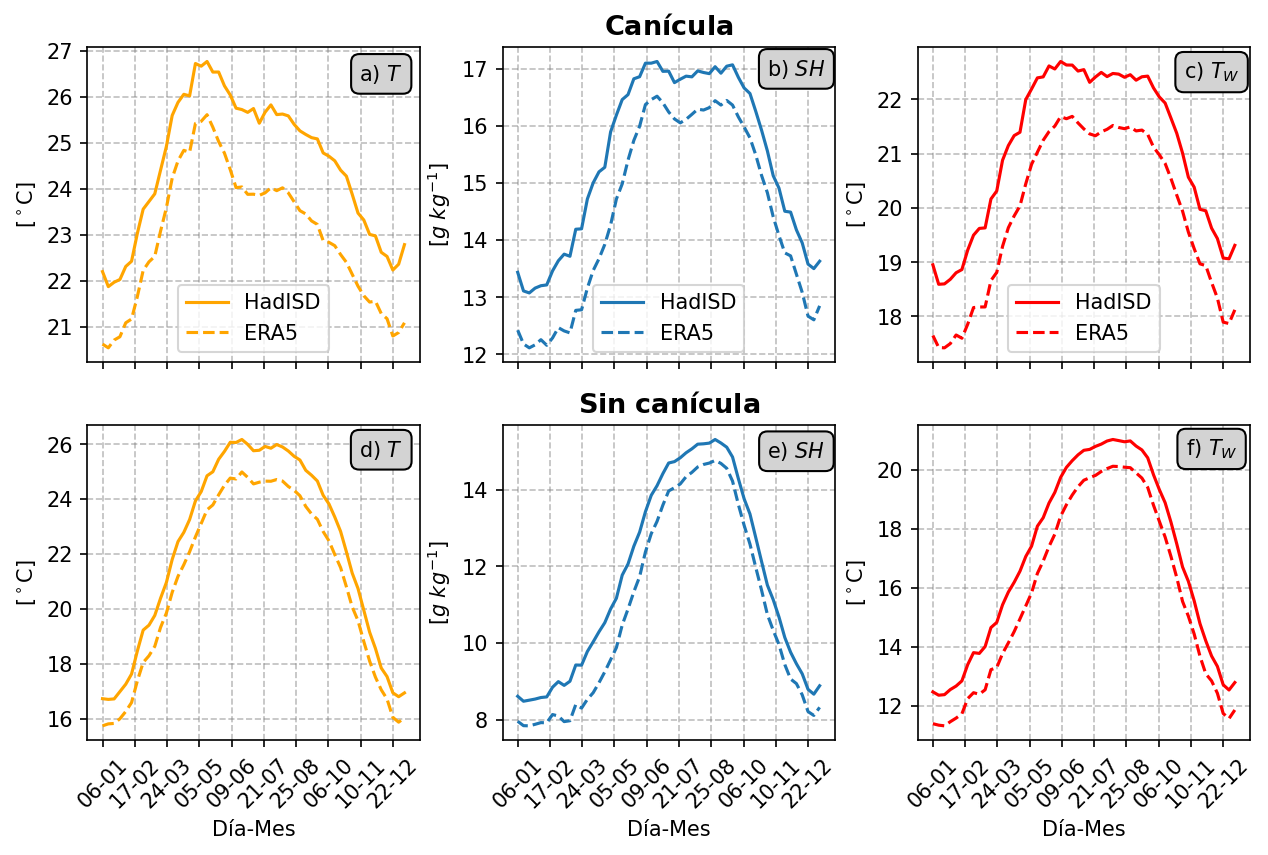

In [21]:
#Graficando la serie de tiempo
fig = plt.figure(figsize=(10, 6),dpi=150)
plt.subplot(2,3,1)

x=HAD_Tw_week.week
y=HAD_T_week
fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x.values  # Usamos `.values` para obtener los enteros
]

plt.plot(fechas,y,label="HadISD",c="orange")

x1=HAD_Tw_week.week
y1=ERA_T_week

fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos `.values` para obtener los enteros
]
plt.plot(fechas1,y1,label="ERA5",c="orange",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')

plt.text(48, 26.5, "a) $T$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.ylabel("[$^\circ$C]")
plt.legend()
plt.xticks(color="white")
plt.xticks(np.linspace(0,50,10))

plt.subplot(2,3,3)
x=HAD_Tw_week.week
y=HAD_Tw_week-273.15

fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x.values  # Usamos .values para obtener los enteros
]
plt.plot(fechas,y,label="HadISD",c="red")

x1=HAD_Tw_week.week
y1=ERA_Tw_week
fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos .values para obtener los enteros
]
plt.plot(fechas1,y1,label="ERA5",c="red",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.text(48, 22.5, "c) $T_{W}$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.ylabel("[$^\circ$C]")

plt.legend()
plt.xticks(color="white")
plt.xticks(np.linspace(0,50,10))

plt.subplot(2,3,2)

x=HAD_Tw_week.week
y=HAD_SH_week*1000
fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x.values  # Usamos .values para obtener los enteros
]
plt.plot(fechas,y,label="HadISD")

x1=HAD_Tw_week.week
y1=ERA_q_week*1000

fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos `.values` para obtener los enteros
]
plt.title(r"$\mathbf{Canícula}$",fontsize=13)

plt.plot(fechas1,y1,label="ERA5",c="#1f77b4",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.text(48, 17, "b) $SH$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.ylabel("[$g$ $kg^{-1}$]")
plt.legend()
plt.xticks(color="white")
plt.xticks(np.linspace(0,50,10))

plt.subplot(2,3,4)

x=HAD_Tw_nweek.week
y=HAD_T_nweek
fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x.values  # Usamos `.values` para obtener los enteros
]
plt.plot(fechas,y,label="HadISD",c="orange")

x1=HAD_Tw_nweek.week
y1=ERA_T_nweek

fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos `.values` para obtener los enteros
]
plt.plot(fechas1,y1,label="ERA5",c="orange",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')

plt.ylabel("[$^\circ$C]")
plt.xlabel("Día-Mes")
plt.xticks(rotation=30)
plt.text(48, 25.8, "d) $T$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.xticks(np.linspace(0,50,10),rotation=45)
plt.subplot(2,3,6)
x=HAD_Tw_nweek.week
y=HAD_Tw_nweek-273.15
fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x.values  # Usamos .values para obtener los enteros
]

plt.plot(fechas,y,label="HadISD",c="red")

x1=HAD_Tw_nweek.week
y1=ERA_Tw_nweek
fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos .values para obtener los enteros
]
plt.plot(fechas1,y1,label="ERA5",c="red",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')

plt.text(48, 20.7, "f) $T_{W}$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.ylabel("[$^\circ$C]")
plt.xlabel("Día-Mes")
plt.xticks(np.linspace(0,50,10),rotation=45)
plt.subplot(2,3,5)
año=2025
x=HAD_Tw_nweek.week
y=HAD_SH_nweek*1000


# Convertir cada semana a fecha (mes y día)
fechas1 = [
    datetime.datetime.strptime(f"2025-W{int(sem)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem in x.values  # Usamos `.values` para obtener los enteros
]

plt.plot(fechas1,y,label="HadISD")
plt.xticks(np.linspace(0,50,10),rotation=45)

x1=HAD_Tw_nweek.week
y1=ERA_q_nweek*1000

# Convertir cada semana a fecha (mes y día)
fechas = [
    datetime.datetime.strptime(f"2025-W{int(sem1)}-1", "%Y-W%W-%w").strftime("%d-%m")
    for sem1 in x1.values  # Usamos `.values` para obtener los enteros
]

plt.plot(fechas,y1,label="ERA5",c="#1f77b4",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.title(r"$\mathbf{Sin}$ $\mathbf{canícula}$",fontsize=13)
plt.text(48, 15, "e) $SH$", fontsize=10, color="black", ha="center", va="center", 
         bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
            
plt.ylabel("[$g$ $kg^{-1}$]")
plt.xlabel("Día-Mes")
plt.subplots_adjust(wspace=0.25)
plt.xticks(np.linspace(0,50,10))

plt.savefig("week_MSD.svg",bbox_inches="tight",dpi=300)
plt.savefig("week_MSD.png",bbox_inches="tight",dpi=300)


plt.show()